In [57]:
import tensorflow as tf
# List all physical GPU devices
physical_devices = tf.config.list_physical_devices('GPU')

if physical_devices:
    try:
        # Enable memory growth for the first GPU
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
        print("Memory growth enabled for:", physical_devices[0])
    except RuntimeError as e:
        # Memory growth must be set before initializing GPUs
        print("Error setting memory growth:", e)
else:
    print("No GPU devices found.")

with tf.device('/cpu:0'):
    import cv2
    import os
    import numpy as np
    import seaborn as sns
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix
    from sklearn.model_selection import train_test_split, GridSearchCV
    from sklearn.svm import LinearSVC
    from sklearn.metrics import classification_report, accuracy_score
    from tensorflow.keras import layers, models
    from sklearn.preprocessing import LabelEncoder,StandardScaler
    from tensorflow.keras.utils import to_categorical
    import numpy as np
    from sklearn.svm import SVC
    from sklearn.metrics import accuracy_score, classification_report
    from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint
    import h5py
    import gc
    import winsound


    gc.enable

    from tensorflow.python.client import device_lib
    print(device_lib.list_local_devices())

Memory growth enabled for: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 297767672909919172
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1362894848
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2940353909516292131
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1660 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [37]:
with tf.device('/cpu:0'):
    # Load the numpy array X from the compressed .npz file
    X_train = np.load(r'C:\Users\princ\Downloads\Vision datasets\workspace\X_train_3.npz')
    X_test  = np.load(r'C:\Users\princ\Downloads\Vision datasets\workspace\X_test_3.npz')
    Y_train = np.load(r'C:\Users\princ\Downloads\Vision datasets\workspace\Y_train_3.npz')
    Y_test  = np.load(r'C:\Users\princ\Downloads\Vision datasets\workspace\Y_test_3.npz')

    # Extract the arrays from the loaded files
    X_train = X_train['X']
    X_test = X_test['X']
    Y_train = Y_train['X']
    Y_test = Y_test['X']
    
    # One-hot encode the labels
    label_encoder = LabelEncoder()
    y_train_encoded = to_categorical(label_encoder.fit_transform(Y_train), num_classes=50)  # Adjust num_classes as needed
    y_test_encoded = to_categorical(label_encoder.transform(Y_test), num_classes=50)
    
    # Set the image input shape
    image_input_shape = X_train[0].shape  # (height, width, channels)
    num_classes = y_train_encoded.shape[1]  # Number of unique classes

In [38]:
# Assuming X_train and X_test are your image data arrays
X_train = X_train.reshape(X_train.shape[0], -1)  # Flatten images into (num_samples, num_features)
X_test = X_test.reshape(X_test.shape[0], -1)

# Standardize the data (if needed, uncomment the scaler)
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# Perform PCA
n_components = 1568  # Number of eigenfaces (latent dimensions)
pca = PCA(n_components=n_components, whiten=True).fit(X_train)

# Transform the data using PCA (project onto the PCA basis)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [39]:
print(X_test_pca.shape)

(758, 1568)


In [40]:
def build_classifier(latent_dim, num_classes):
    classifier = models.Sequential(name="classifier_x")
    classifier.add(layers.InputLayer(input_shape=latent_dim))  # Specify input shape as latent dimensions
    classifier.add(layers.Dense(4096, activation='linear'))  # Fully connected layer
    classifier.add(layers.Dense(num_classes, activation='softmax'))  # Output layer for classification
    return classifier

latent_dim_encoder = (n_components,)  # PCA latent dimension (1568)
model3 = build_classifier(latent_dim_encoder, num_classes)
model3.summary()

Model: "classifier_x"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 4096)              6426624   
                                                                 
 dense_17 (Dense)            (None, 50)                204850    
                                                                 
Total params: 6,631,474
Trainable params: 6,631,474
Non-trainable params: 0
_________________________________________________________________


In [44]:
# Initialize the classifier
classifier_model = build_classifier(latent_dim_encoder, num_classes)

# Compile the classifier model
classifier_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [45]:
with tf.device('/gpu:0'):
    early_stop2 = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, min_delta=1e-4)

    # Train the Encoder-Classifier Model
# Now, instead of using PCA directly in the model, you can fit the model using the PCA features:
    history = classifier_model.fit(
        X_train_pca, y_train_encoded,
        epochs=200,
        callbacks = [early_stop2],
        batch_size=32,
        validation_data=(X_test_pca, y_test_encoded),
        shuffle = True)


Epoch 1/200
135/135 [==============================] - 1s 6ms/step - loss: 4.3643 - accuracy: 0.0217 - val_loss: 4.1630 - val_accuracy: 0.0435
Epoch 2/200
135/135 [==============================] - 1s 4ms/step - loss: 3.9378 - accuracy: 0.0564 - val_loss: 3.9727 - val_accuracy: 0.0594
Epoch 3/200
135/135 [==============================] - 1s 4ms/step - loss: 3.5471 - accuracy: 0.1156 - val_loss: 3.7888 - val_accuracy: 0.0910
Epoch 4/200
135/135 [==============================] - 1s 4ms/step - loss: 3.1748 - accuracy: 0.2172 - val_loss: 3.6161 - val_accuracy: 0.1372
Epoch 5/200
135/135 [==============================] - 1s 4ms/step - loss: 2.8245 - accuracy: 0.3382 - val_loss: 3.4579 - val_accuracy: 0.1834
Epoch 6/200
135/135 [==============================] - 1s 4ms/step - loss: 2.4997 - accuracy: 0.4702 - val_loss: 3.3121 - val_accuracy: 0.2216
Epoch 7/200
135/135 [==============================] - 1s 4ms/step - loss: 2.2031 - accuracy: 0.5995 - val_loss: 3.1764 - val_accuracy: 0.2704

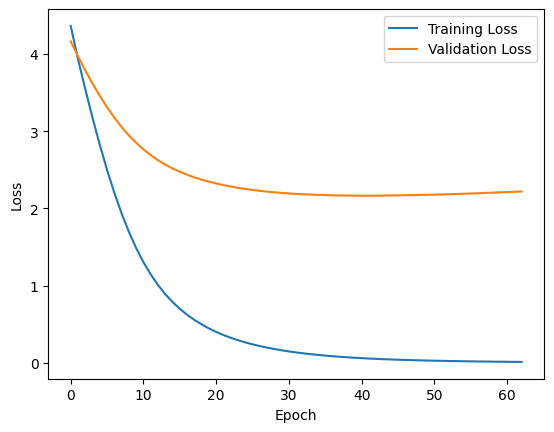

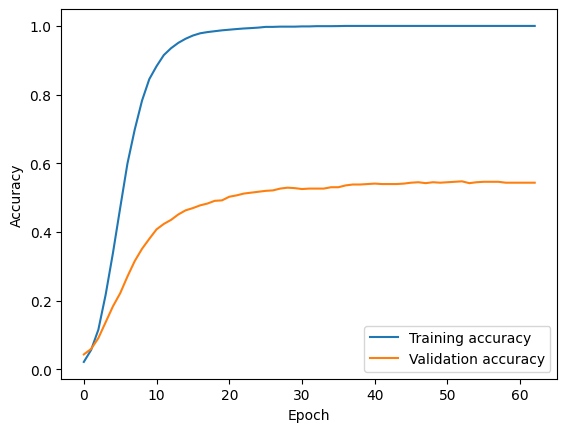

In [46]:
with tf.device('/cpu:0'):
    loss = history.history['loss']
    val_Loss = history.history['val_loss']
    plt.plot(loss, label='Training Loss')
    plt.plot(val_Loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


    Accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    plt.plot(Accuracy, label='Training accuracy')
    plt.plot(val_accuracy, label='Validation accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [58]:
winsound.Beep(300, 500)  # Frequency: 1000 Hz, Duration: 500 ms
winsound.Beep(300, 500)  # Frequency: 1000 Hz, Duration: 500 ms
winsound.Beep(300, 500)  # Frequency: 1000 Hz, Duration: 500 ms
winsound.Beep(800, 800)  # Frequency: 1000 Hz, Duration: 500 ms

In [59]:
gc.collect()
tf.keras.backend.clear_session()

In [60]:
# Print training summary
print("Training completed!")
# Step 1: Generate predictions
predictions = classifier_model.predict(X_test_pca)
# Step 2: Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)
# Step 3: Get true class labels (decode if one-hot encoded)
true_classes = np.argmax(y_test_encoded, axis=1)
# Step 4: Calculate accuracy
accuracy = np.mean(predicted_classes == true_classes)
print(f"Prediction Accuracy: {accuracy * 100:.2f}%")

Training completed!
24/24 [==============================] - 0s 12ms/step
Prediction Accuracy: 54.75%


In [61]:
def visualize_results(y_test, y_predict):
    # Convert predictions to class labels (if necessary)
    y_predict_class = np.argmax(y_predict, axis=1)
    
    # Convert y_test from one-hot encoding to class labels (if necessary)
    y_test_class = np.argmax(y_test, axis=1)  # Only if y_test is one-hot encoded

    # Compute confusion matrix
    cm = confusion_matrix(y_test_class, y_predict_class)

    # Plot confusion matrix with a wider figure
    plt.figure(figsize=(23, 23))  # Wider graph: 12 units wide, 6 units high
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(len(np.unique(y_test_class))), yticklabels=np.arange(len(np.unique(y_test_class))))
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

def class_wise_accuracy(y_test, y_predict):
    # Convert predictions and ground truth to class labels (if necessary)
    y_predict_class = np.argmax(y_predict, axis=1)  # for multi-class outputs
    y_test_class = np.argmax(y_test, axis=1)  # for one-hot encoded labels

    # Compute confusion matrix
    cm = confusion_matrix(y_test_class, y_predict_class)

    # Calculate class-wise accuracy
    class_accuracies = cm.diagonal() / cm.sum(axis=1)  # Diagonal elements (correct predictions) / Row sums (total class instances)

    # Print class-wise accuracy
    #print("Class-wise accuracy:")
    #for i, accuracy in enumerate(class_accuracies):
    #    print(f"Class {i}: {accuracy * 100:.2f}%")

    # Plot class-wise accuracy as a bar chart with a wider figure
    plt.figure(figsize=(20, 6))  # Wider graph: 12 units wide, 6 units high
    plt.bar(range(len(class_accuracies)), class_accuracies * 100, color='skyblue')
    plt.xlabel('Class')
    plt.ylabel('Accuracy (%)')
    plt.title('Class-wise Accuracy')
    plt.xticks(range(len(class_accuracies)))
    plt.ylim(0, 100)
    plt.show()

    return class_accuracies

import matplotlib.pyplot as plt
import numpy as np

def show_images_from_class(X, y, class_label, num_images=5):
    """
    Display a given number of images from a specified class, arranged with 5 images per row.
    
    Parameters:
    - X: The image data (features) as a numpy array or pandas dataframe.
    - y: The labels corresponding to the images.
    - class_label: The class label for which to show the images.
    - num_images: Number of images to display (default is 5).
    """
    # Find the indices of the images that belong to the given class
    class_indices = np.where(y == class_label)[0]
    
    # Randomly select 'num_images' indices from the class
    selected_indices = np.random.choice(class_indices, num_images, replace=False)
    
    # Calculate the number of rows needed to display the images in 5 per row
    num_rows = (num_images // 5) + (num_images % 5 != 0)
    
    # Set up the plot
    plt.figure(figsize=(15, 3 * num_rows))
    
    for i, idx in enumerate(selected_indices):
        plt.subplot(num_rows, 5, i+1)  # Rows x 5 columns
        plt.imshow(X[idx], cmap='gray')  # Assuming grayscale images, adjust if RGB
        plt.title(f"Class {class_label}")
        plt.axis('off')  # Hide axes
    
    plt.show()



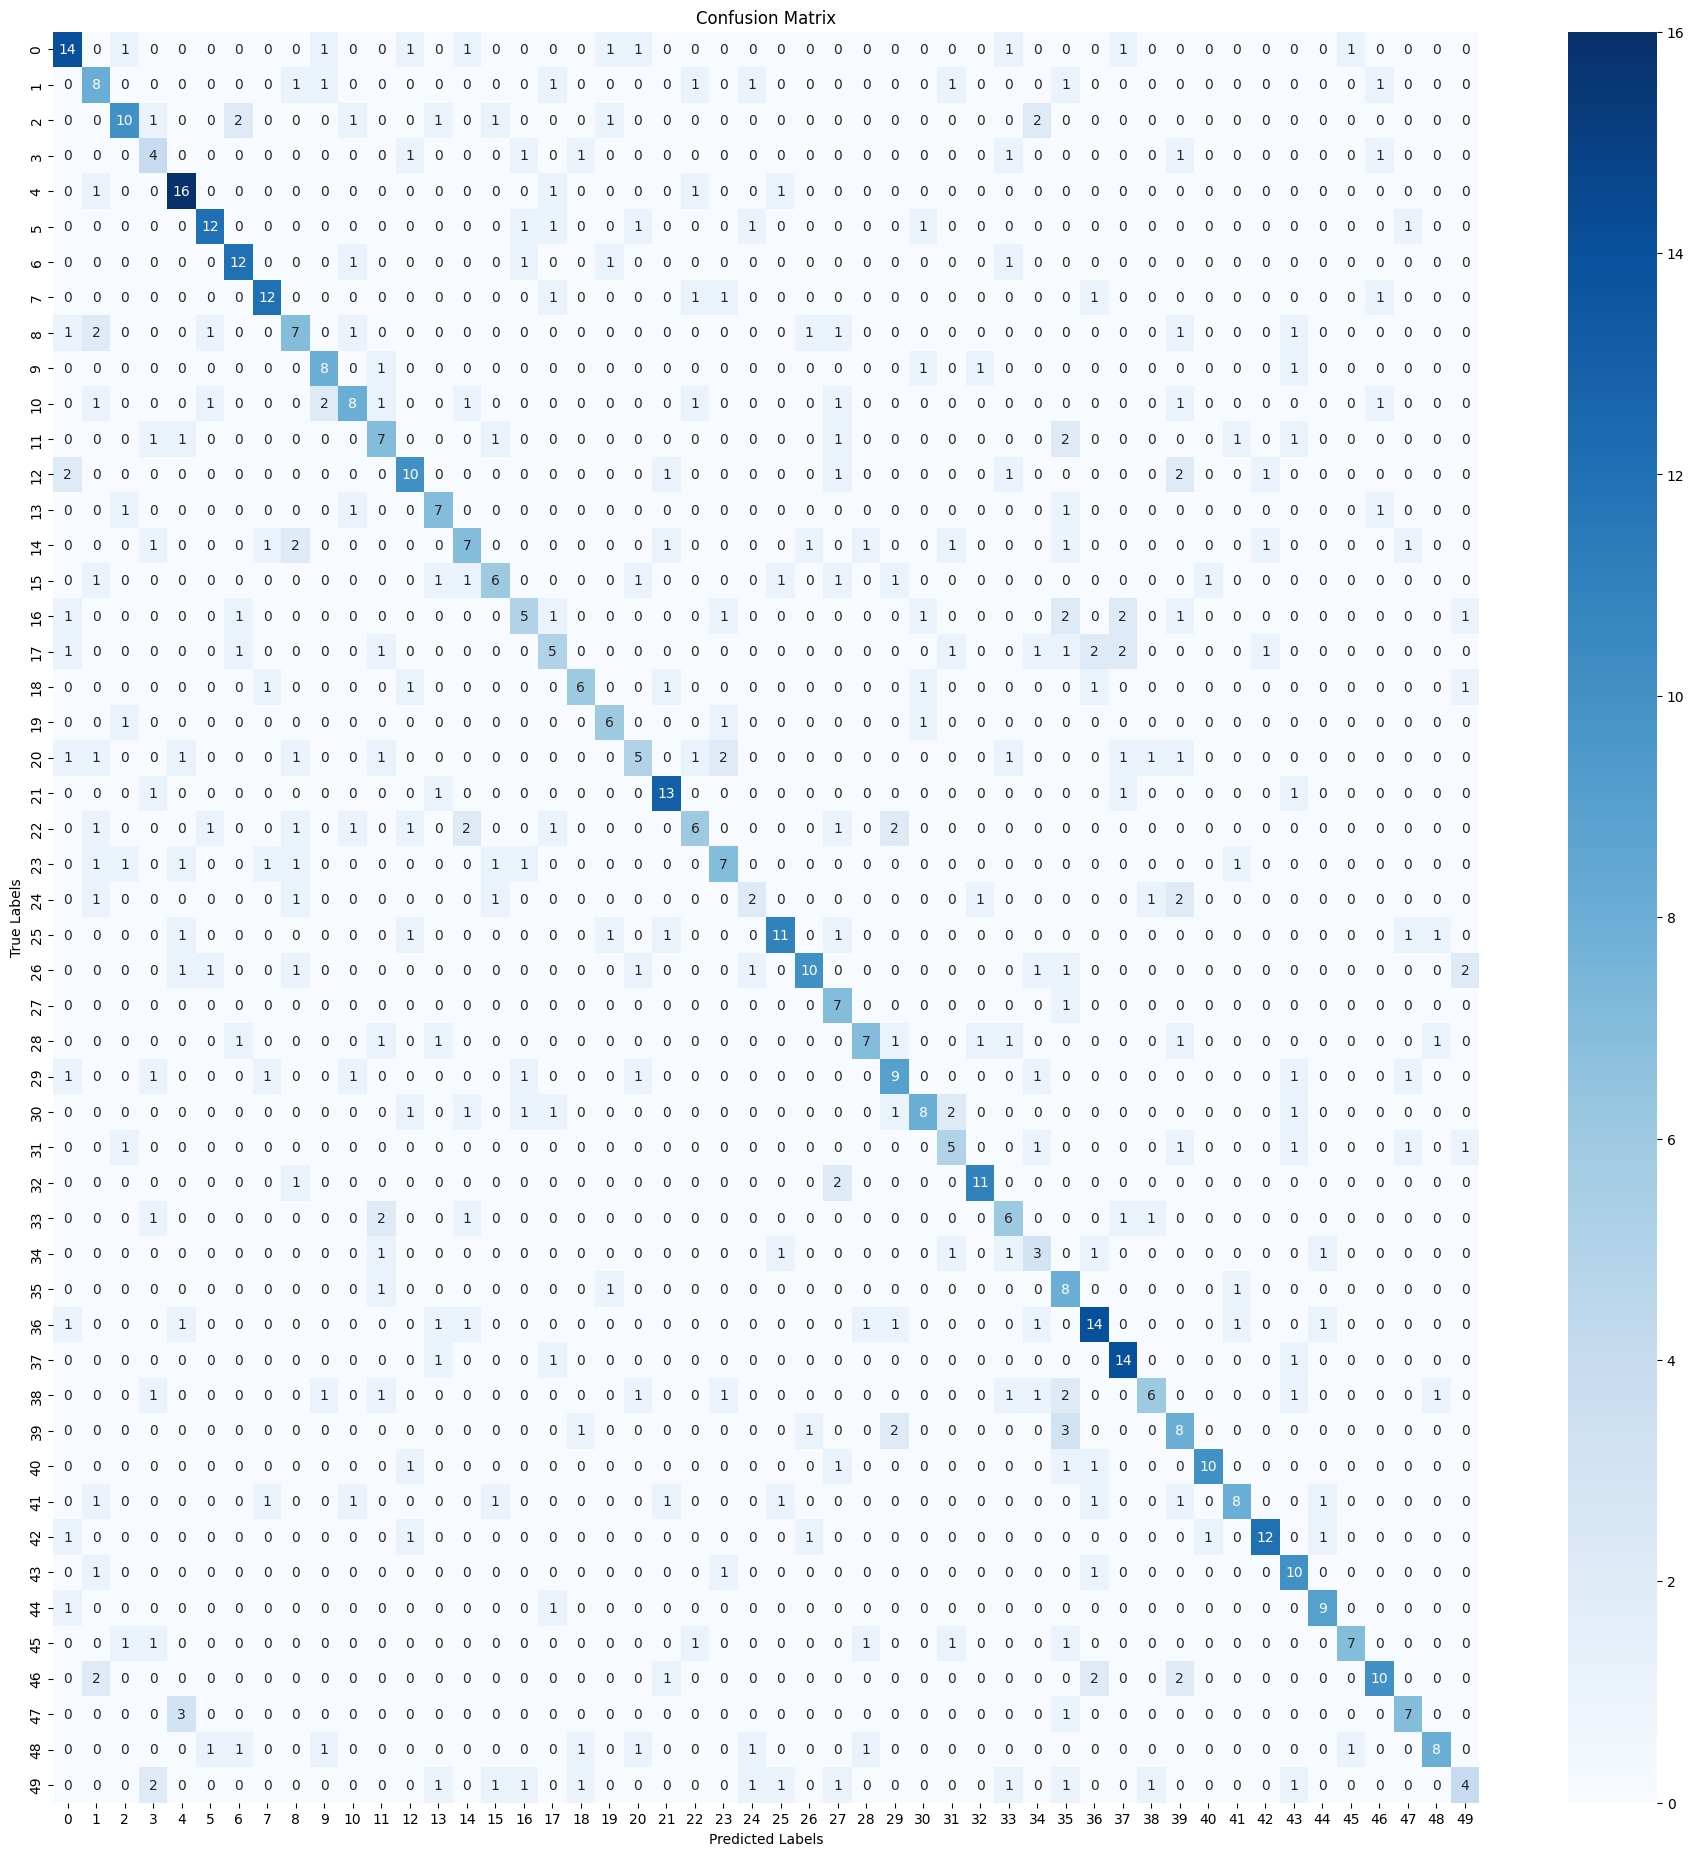

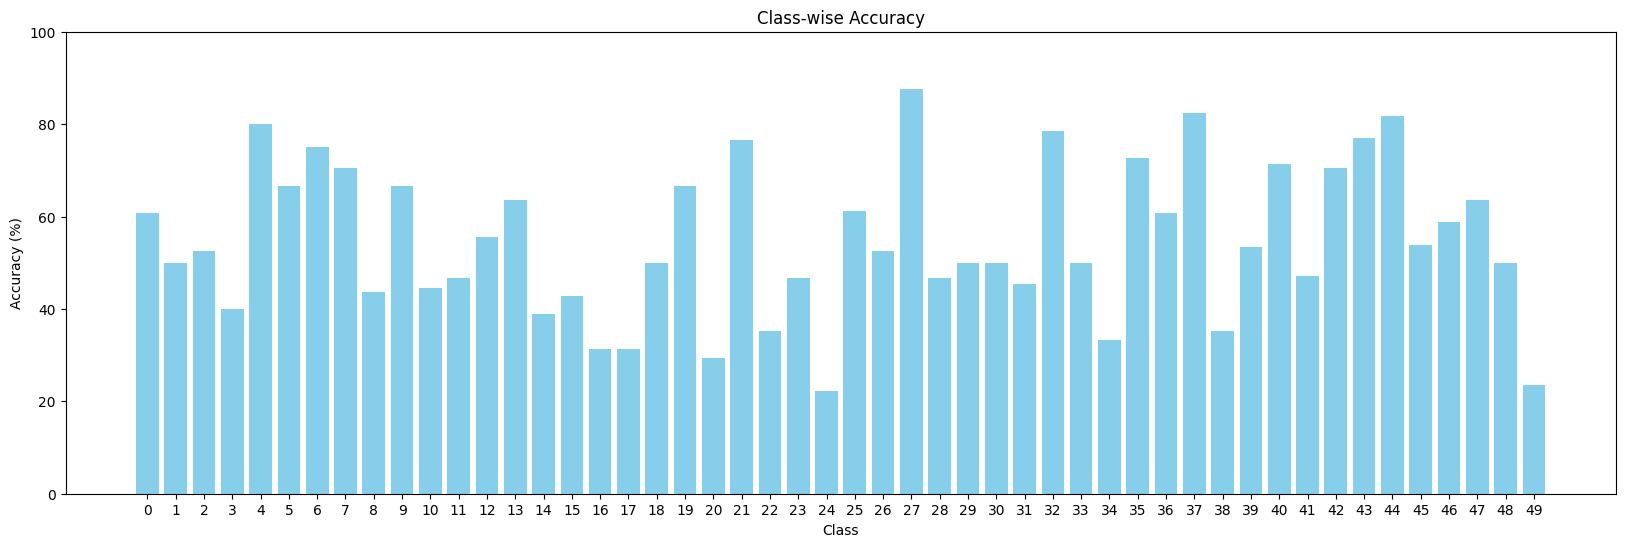

ValueError: 'a' cannot be empty unless no samples are taken

In [62]:

visualize_results(y_test_encoded, predictions)
class_wise_accuracy(y_test_encoded, predictions)
show_images_from_class(X_train_pca, y_train_encoded, class_label=12, num_images=30)
